# Using a Modflow UZF model as a stressmodel in Pastas

In [1]:
import os

import flopy
import pandas as pd
import pastas as ps

import pastas_plugins.modflow as ppmf

from pastas.timer import SolveTimer

ps.set_log_level("ERROR")

bindir = "bin"
mf6_exe = os.path.join(bindir, "mf6")
if not os.path.isfile(mf6_exe):
    if not os.path.isdir(bindir):
        os.makedirs(bindir)
    flopy.utils.get_modflow("bin", repo="modflow6")

## Data Groundwater Article

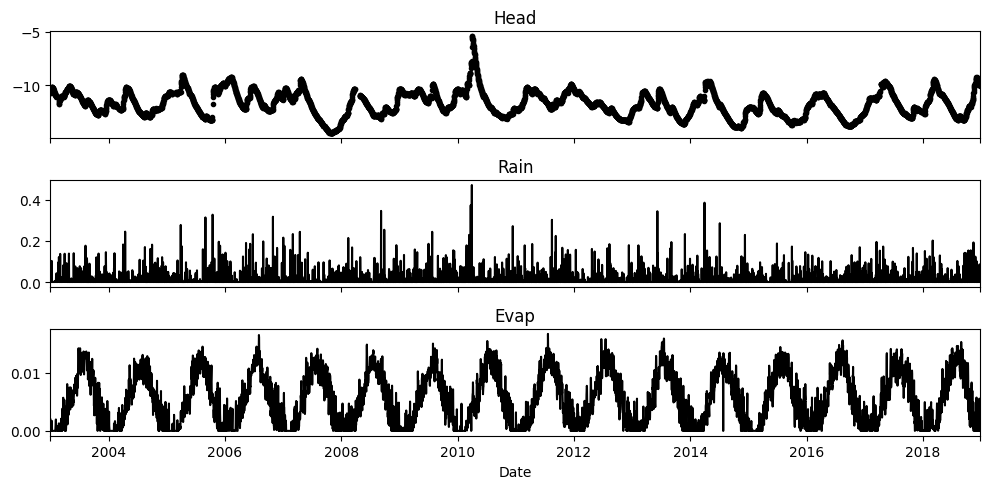

In [2]:
ds = ps.load_dataset("collenteur_2019")
head = ds["head"].squeeze()
prec = ds["rain"].squeeze().resample("D").asfreq().fillna(0.0)
evap = ds["evap"].squeeze()

tmin = pd.Timestamp("2003-01-01")
tmax = pd.Timestamp("2018-12-25")

ps.plots.series(head, [prec, evap], hist=False);

### Standard exponential model

Fit report Head                   Fit Statistics
nfev    11                     EVP         87.10
nobs    5737                   R2           0.87
noise   False                  RMSE         0.42
tmin    2003-01-01 00:00:00    AICc     -9870.13
tmax    2018-12-25 00:00:00    BIC      -9843.52
freq    D                      Obj        512.71
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal    initial  vary
exp_A       331.311203  29.925748  True
exp_a        98.430976  10.000000  True
exp_f        -0.854493  -1.000000  True
constant_d  -14.150486 -11.740288  True


<Axes: xlabel='Date', ylabel='Head'>

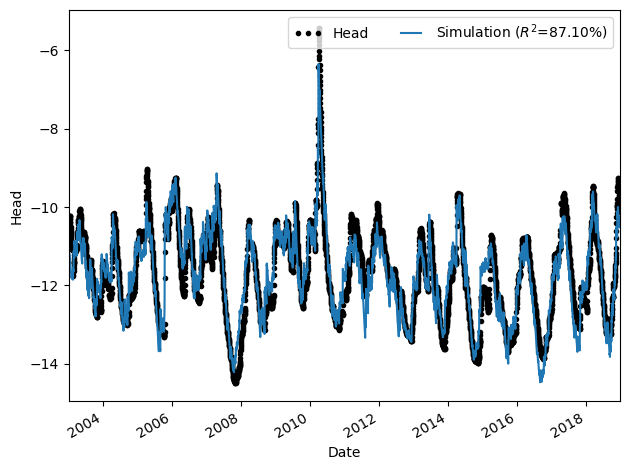

In [3]:
mlexp = ps.Model(head)
mlexp.add_stressmodel(
    ps.RechargeModel(prec=prec, evap=evap, rfunc=ps.Exponential(), name="exp")
)
mlexp.solve(tmin=tmin, tmax=tmax)
mlexp.plot()

## FLEX model

Fit report Head                    Fit Statistics
nfev    32                     EVP          89.09
nobs    5737                   R2            0.89
noise   False                  RMSE          0.39
tmin    2003-01-01 00:00:00    AICc     -10827.00
tmax    2018-12-25 00:00:00    BIC      -10787.08
freq    D                      Obj         433.65
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (6 optimized)
               optimal     initial   vary
flex_A        0.472212    0.074380   True
flex_a       99.246846   10.000000   True
flex_srmax  250.000000  250.000000  False
flex_lp       0.250000    0.250000  False
flex_ks     167.022904  100.000000   True
flex_gamma    3.833278    2.000000   True
flex_kv       0.956051    1.000000   True
flex_simax    2.000000    2.000000  False
constant_d  -15.288913  -11.740288   True


<Axes: xlabel='Date', ylabel='Head'>

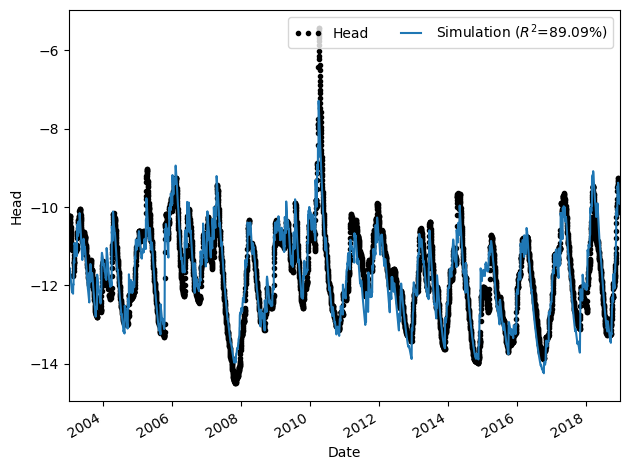

In [4]:
mlflex = ps.Model(head)
rm = ps.RechargeModel(
    prec=prec.multiply(1e3),
    evap=evap.multiply(1e3),
    rfunc=ps.Exponential(),
    recharge=ps.rch.FlexModel(),
    name="flex",
)
mlflex.add_stressmodel(rm)
mlflex.set_parameter(f"{rm.name}_srmax", vary=False)
mlflex.solve(tmin=tmin, tmax=tmax)
mlflex.plot()

### UZF model

With some optimal parameters from exponential model

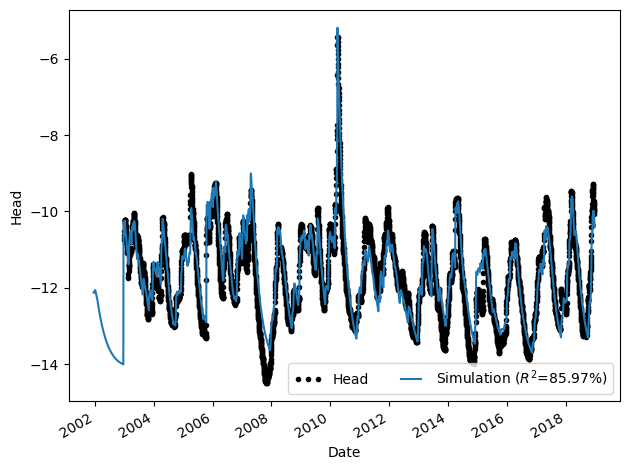

In [7]:
mlumf = ps.Model(head)

expmf = ppmf.ModflowUzf(exe_name=mf6_exe, sim_ws="mf_files/uzf_gw", head=head)
expsm = ppmf.ModflowModel(prec=prec, evap=evap, modflow=expmf, name="uzfsm")
mlumf.add_stressmodel(expsm)
mlumf.set_parameter(
    f"{expsm.name}_s",
    initial=mlexp.parameters.at["exp_a", "optimal"]
    / mlexp.parameters.at["exp_A", "optimal"],
    vary=False,
)
mlumf.set_parameter(
    f"{expsm.name}_c", initial=mlexp.parameters.at["exp_A", "optimal"], vary=False
)
constant_d = mlexp.parameters.at["constant_d", "optimal"]
if "constant_d" in mlumf.parameters.index:
    mlumf.set_parameter("constant_d", initial=constant_d, vary=False)
    if expmf._head is not None:
        mlumf.del_constant()
        mlumf.set_parameter(f"{expsm.name}_d", initial=constant_d, vary=False)

# choose height high enough above constant_d and the largest head value
# otherwise you get runoff via the drn package (originally simulate_gwseep=True)
mlumf.set_parameter(f"{expsm.name}_height", initial=10.0, vary=False)

ax = mlumf.plot()

In [8]:
mlumf.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
uzfsm_d,-14.150486,-14.500,-5.420000e+00,False,uzfsm,uniform,NaN,NaN
uzfsm_c,331.311203,10.000,1.000000e+08,False,uzfsm,uniform,NaN,NaN
uzfsm_s,0.297095,0.001,5.000000e-01,False,uzfsm,uniform,NaN,NaN
uzfsm_height,10.000000,0.010,1.000000e+01,False,uzfsm,uniform,NaN,NaN
uzfsm_vks,1.000000,0.000,1.000000e+01,True,uzfsm,uniform,NaN,NaN
uzfsm_thtr,0.100000,0.000,2.000000e-01,True,uzfsm,uniform,NaN,NaN
uzfsm_thts,0.300000,0.200,4.000000e-01,True,uzfsm,uniform,NaN,NaN
uzfsm_thextfrac,0.100000,0.000,1.000000e+00,True,uzfsm,uniform,NaN,NaN
uzfsm_eps,5.000000,3.500,1.000000e+01,True,uzfsm,uniform,NaN,NaN
uzfsm_extdpfrac,0.500000,0.000,1.000000e+00,True,uzfsm,uniform,NaN,NaN


### UZF model calibrated

In [7]:
ml = ps.Model(head)
ml.del_constant()

# shorten the warmup to speed up the modflow calculation somewhat.
ml.settings["warmup"] = pd.Timedelta(days=4 * 365)
mf = ppmf.ModflowUzf(
    exe_name=mf6_exe,
    sim_ws="mf_files/mfuzf_gw",
    head=head,
    ntrailwaves=35,
    nwavesets=100,
)
sm = ppmf.ModflowModel(prec, evap, modflow=mf, name="mfsm")
ml.add_stressmodel(sm)

ml.set_parameter(f"{sm.name}_d", pmin=-15.0)

with SolveTimer() as st:
    ml.solve(callback=st.timer, tmin=tmin, tmax=tmax, diff_step=0.1)

Optimization progress: 0it [00:00, ?it/s]

Optimization progress: 201it [18:38,  5.56s/it]

Fit report Head                    Fit Statistics
nfev    30                     EVP          91.54
nobs    5737                   R2            0.92
noise   False                  RMSE          0.34
tmin    2003-01-01 00:00:00    AICc     -12279.67
tmax    2018-12-25 00:00:00    BIC      -12219.81
freq    D                      Obj         336.29
warmup  1460 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (9 optimized)
                   optimal     initial  vary
mfsm_d          -14.214659  -11.740288  True
mfsm_c          315.829023  220.000000  True
mfsm_s            0.275418    0.050000  True
mfsm_height       8.603391    1.000000  True
mfsm_vks          9.477940    1.000000  True
mfsm_thtr         0.032361    0.100000  True
mfsm_thts         0.237595    0.300000  True
mfsm_eps          5.854889    5.000000  True
mfsm_extdpfrac    1.000000    0.500000  True

Warnings! (2)
Parameter 'mfsm_extdpfrac' on upper bound: 1.00e+00
Respons

### Compare

(12783.0, 17890.0)

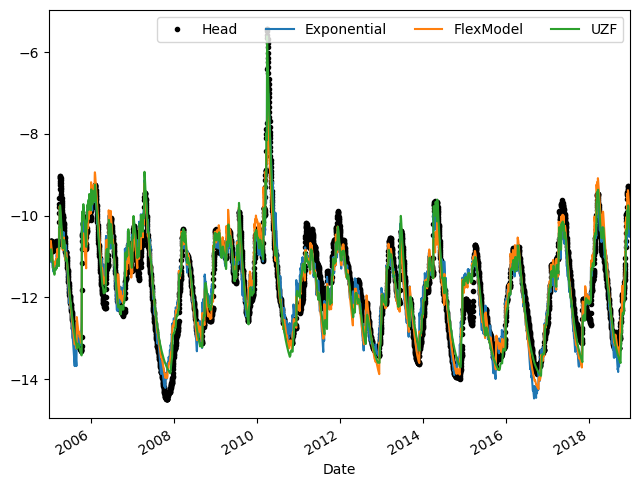

In [15]:
ax = ml.observations().plot(
    marker=".", color="k", linestyle="None", legend=False, figsize=(7.5, 6)
)
mlexp.simulate().plot(ax=ax, label="Exponential")
mlflex.simulate().plot(ax=ax, label="FlexModel")
ml.simulate().plot(ax=ax, label="UZF")
ax.legend(ncol=4, loc="upper right")
ax.set_xlim(tmin + pd.Timedelta(days=2 * 365), tmax)

## Synthetic data

In [9]:
ds = ps.load_dataset("vonk_2024")
head = ds["heads"].loc[:, ("SandyLoam", "D85", "x00")].rename("usg_head").iloc[1:]
prec = ds["stresses"].loc[:, "prec [m/d]"].rename("prec")
evap = ds["stresses"].loc[:, "evap [m/d]"].rename("evap")

tmin = pd.Timestamp("2000-01-01")
tmax = head.index[-1]

### UZF model with parameters we "know" from USG

<Axes: ylabel='Head'>

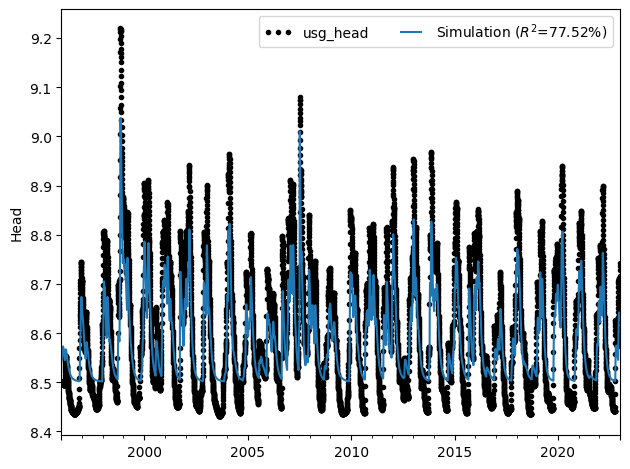

In [10]:
mlu = ps.Model(head)
mlu.del_constant()

mf = ppmf.ModflowUzf(
    exe_name=mf6_exe,
    sim_ws="mf_files/mfuzf_usg",
    head=head,
    ntrailwaves=35,
    nwavesets=100,
)
sm = ppmf.ModflowModel(prec, evap, modflow=mf, name="mfsm")
mlu.add_stressmodel(sm)

# only parameter we don't know
mlu.set_parameter(f"{sm.name}_c", initial=100.0)  # select by hand
# plugin "true" parameters from modflow usg model
mlu.set_parameter(f"{sm.name}_d", initial=8.5)  # level in canal
mlu.set_parameter(
    f"{sm.name}_s", initial=0.271
)  # specific yield from theta_s - theta_fc
mlu.set_parameter(f"{sm.name}_height", initial=1.5)  # freeboard
mlu.set_parameter(f"{sm.name}_vks", initial=1.0061)  # m/day
mlu.set_parameter(f"{sm.name}_thtr", initial=0.065)  # theta_r
mlu.set_parameter(f"{sm.name}_thts", initial=0.41, pmax=0.45)  # theta_s
mlu.set_parameter(f"{sm.name}_eps", initial=4.954)  # brooks in mfusg
mlu.set_parameter(f"{sm.name}_extdpfrac", initial=1.0 / 1.5)  # root depth 1 m

mlu.plot()

### UZF model calibrated

In [11]:
with SolveTimer() as st:
    mlu.solve(callback=st.timer, diff_step=0.1)

Optimization progress: 160it [42:34, 15.96s/it]

Fit report usg_head                Fit Statistics
nfev    16                     EVP          97.57
nobs    9862                   R2            0.98
noise   False                  RMSE          0.02
tmin    1996-01-01 00:00:00    AICc     -76352.72
tmax    2022-12-31 00:00:00    BIC      -76287.97
freq    D                      Obj           2.14
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (9 optimized)
                   optimal     initial  vary
mfsm_d            8.454669    8.500000  True
mfsm_c          161.112127  100.000000  True
mfsm_s            0.217382    0.271000  True
mfsm_height       2.429316    1.500000  True
mfsm_vks          1.074913    1.006100  True
mfsm_thtr         0.124601    0.065000  True
mfsm_thts         0.250819    0.410000  True
mfsm_eps          4.862579    4.954000  True
mfsm_extdpfrac    0.926662    0.666667  True

Warnings! (1)
Response tmax for 'mfsm' > than calibration period.


<Axes: ylabel='Head'>

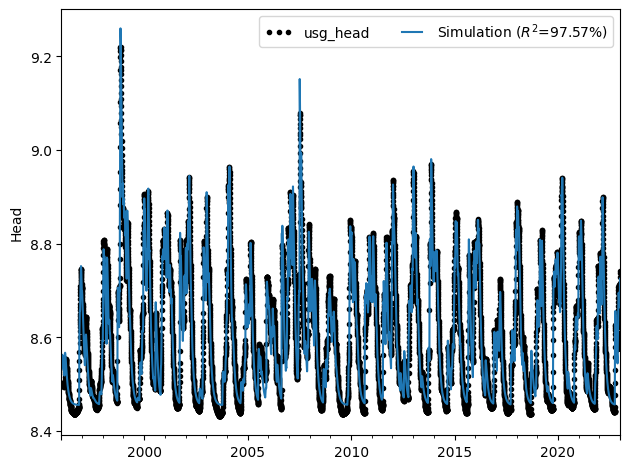

In [12]:
mlu.plot()